<small><i>December 2016- This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol). Source and license info are in the folder.</i></small>

# Decision trees

Decision trees are another kind of intutive classification strategy based on the divide and conquer paradigm. 

The basic **idea** in decision trees is to partition the space in patches and fit a model in that patch. There are two questions to answer in order to implement this solution:

+ How do we partition the space?
+ What model to use in each patch?

In classification trees the second question is straight forward, each patch is given the value of a label and all data falling in that part of the space will be predicted as such.

## 3.1 Decision tree modeling

Elements:

- Splits using axis-orthogonal hyperplanes. This is the key that allows "interpretability" of the results.

- At each internal node we test a value of a feature. A feature and a threshold are stored for each internal node.  

- Leaves makes the class prediction. If leaves are pure, we have to store the class label. If leaves are impure, then the fraction of samples for each class is stored and its frequency is returned when queried.



### 3.1.1 Building our intuition on decision trees

Let us build up our intuition with a simple example.

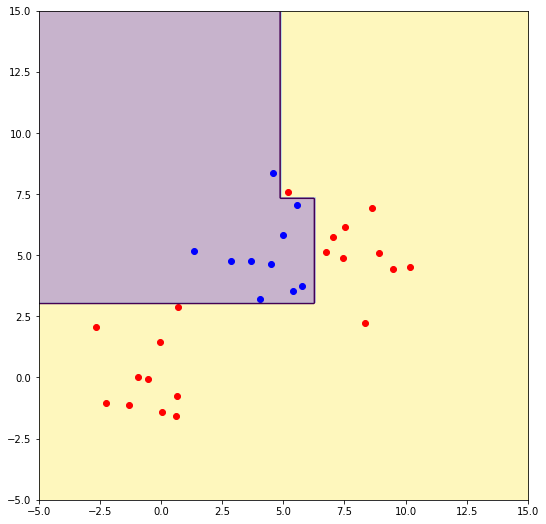

In [1]:
#Let's see what the boundary looks like in a toy problem.
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
MAXN=10
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

from sklearn import tree
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

In [2]:
#Export Tree
import os
dotfile = open("toy_tree.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile)
dotfile.close()

os.system("dot -Tpng toy_tree.dot -o toy_tree.png")

sh: dot: command not found


32512

<img src = "toy_tree.png">

Let us check the meaning of the tree. The first node splits the training set using feature $1$ by applying the threshold $\leq 3.04$. As a result we are able to correctly classify eleven of the thirty data points. Let us see the boundary in that case.

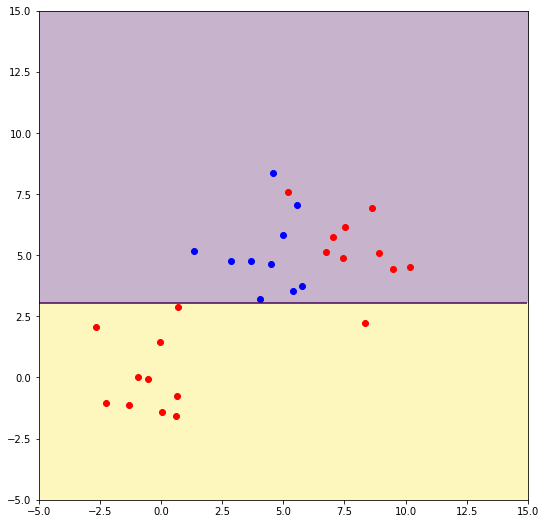

In [3]:
clf = tree.DecisionTreeClassifier(random_state=0,max_depth=1)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')


plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

The second node splits the training set using feature $0$ by applying the threshold $\leq 6.25$. Note that this only is used in the part of the space where feature $1$ is greater  than $3.04$. Observe that the remaining blue space is characterized by the following logical function: $(x_1>3.04) \wedge (x_0\leq 6.25)$

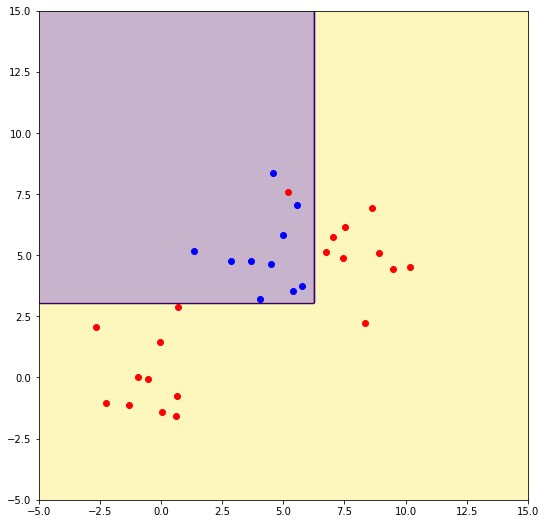

In [4]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=2)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

What is great about decision trees?

+ Trees are easy for humans to interpret. It can be seen as a set of rules. Each path from root to one leaf of the tree is an AND combination of the thresholded features.
+ Given a finite data set, decision trees can express any function of the input attributes. In ${\bf R}^d$ we can isolate every point in the data set by constructing a box around each of them.
+ There can be more than one tree that fits the same data. From all of them we would like a tree with minimum number of nodes. But the problem is NP.

###  Learning the tree

Because the problem is NP we can resort to a greedy construction algorithm. Greedy algorithms choose the current best binary partition without taking into account its impact on the quality of subsequent splits.

The algorithm idea is as follows:

+ Initialize the algorithm with a node associated to the full data set. 

**while** the list is not empty
1. Retrieve the first node from the list.
2. Find the data associated to that node.
3. Find a splitting point.
4. If the node is splittable, create the nodes linked to the parent node and put them in the exploration list.

#### The splitting criterion

There are many different splitting criteria. The most common ones are:

+ Misclassification error
+ Gini index
+ Cross-entropy/Information gain/Mutual information

Withouth going into details, misclassification error splits greedily select the split that corrects more data at each point. Gini index and cross-entropy probabilistically model the notion of impurity of a node. The split is chosen so that the average purity of the new nodes is maximized. Observe that as we descend in the tree the purity increases and eventually converge to pure leaves. A nice way of thinking about entropy is Pedro Domingos' simile with surprise. Entropy measures the average surprise/information a probabilistic result yields. In a binary variable, the maximum surprise occurs when both outcomes are equally probable, one has the maximum uncertainty on the result. Otherwise, the surprise decreases. This behavior is also display in Gini's index.

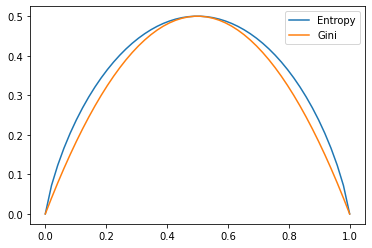

In [5]:
import numpy as np
entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0
gini = lambda p: 1. - (np.array(p)**2).sum()
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p])/2. for p in pvals], label='Entropy')
plt.plot(pvals, [gini([p,1-p]) for p in pvals], label='Gini')
plt.legend()

### Trees and overfitting

Because trees are very expressive models they can model any training set perfectly and easily overfit.

There are two ways of avoiding overfitting in trees:

+ Stop growing the tree when the split is not statistically significant.
+ Grow a full tree and post-prune.

One of the simplest ways of post pruning is **reduced error prunning**. It goes like this,

1. Split data into training and validation
2. Create a candidate tree on the training set
3. Do until further pruning is harmful
    1. Evaluate impact on the validation set of removing each posible node (with descendants)
    2. Greedily remove the node that improves the performance the most.
    
Pruning is not implemented in sklearn at this moment. 

# Introduction to ensemble learning

When we want to purchase a product we usually read user's reviews. Before undergoing a major surjery procedure we seek the opinion of different experts. Ensemble learning mimicks one of the human uncertainty reduction mechanism, seeking additional opinions before making a major decision.

Ensemble learning is divided in two steps:

1. Train a set of classifiers
2. Aggregate their results

There are different reasons for using ensemble learning in practice:

1. **Statistical reasons:** The combination of outputs of different classifiers may reduce the risk of an unfortunate selection of a poorly performing classifier.
2. **Large scale data sets:** It makes little sense to only have one classifier on very large sets of data. Partition data in smaller subsets and aggregate seems like a good idea.
3. **Divide and conquer:** Some problems too difficult for a single classifier to solve. The decision boundary may be too complex or lie outside the space of functions of the classifier.
4. **Data fusion:** Different source fusion is usually a problem. One usually faces data coming from heterogeneous sources and the question is how to fuse these data. One solution is to train one classifier per source and the fuse the decision of those experts.

## Diversity

One condition required for the system to work is that errors on different classifiers should be made on different samples in order for the strategic combination of the classifiers to correct possible errors in the judgement of the class o a particular instance. This effect has been called **diversity**.

Diversity can be obtained in different ways:

+ Using different training sets. Use resampling strategies to obtain different optimal classifiers. This effect is correlated with the notion of stability of the classifier and the concept of bias and variance of the classifier.
+ Using different training parameters for different classifiers
+ Combining different architectures. (i.e. svm, decission trees, ...)
+ Training on different features. (i.e. random subspaces or random projections)

## Different kinds of ensemble models

From a topological and architectural point of view, we can find three great ways for building an ensemble:

- **Bagging:** Horitzontal aggregation. All elements trained outputs are combined using some aggregation rule. In bagging the elements combined are trained independently.
- **Boosting:** Horitzontal aggregation. Each component in the aggregation depends on all the others. In this kind of techniques the two most well known approaches for linking members are the notions of residual (gradient boosting) or statistical resampling (adaptive boosting). 
- **Stacking:** Vertical aggregation. In this kind of techniques the output of one member of the ensemble is the input for the next member. For example, each layer in a neural network is vertically stacked.

## Bootstrapping aggregation 

Bootstrapping means resampling the training data set with replacement. Usually the same number of data as the original data set is used.

**Bootstrapping aggregation (aka. Bagging)** is a ensemble technique that uses multiple bootstrapped copies of the training set to build a set of classifiers. One classifier for each bootstrapped training copy. And then, use a combination technique, such as majority voting, in order to take the final decision.

Let us check, how it works.

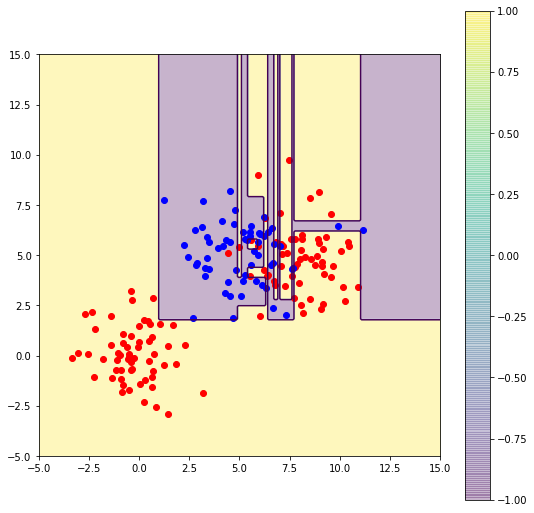

In [6]:
#Let us train an overfitted classifier. For example an SVC.
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
MAXN=60
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1

from sklearn import tree
from sklearn import metrics

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]


clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X,y.ravel())
Z=clf.predict(data)
mx= np.max(Z)
mn= np.min(Z)
Z.shape=sz
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,Z,[0])

fig = plt.gcf()
fig.set_size_inches(9,9)


Process finnished.


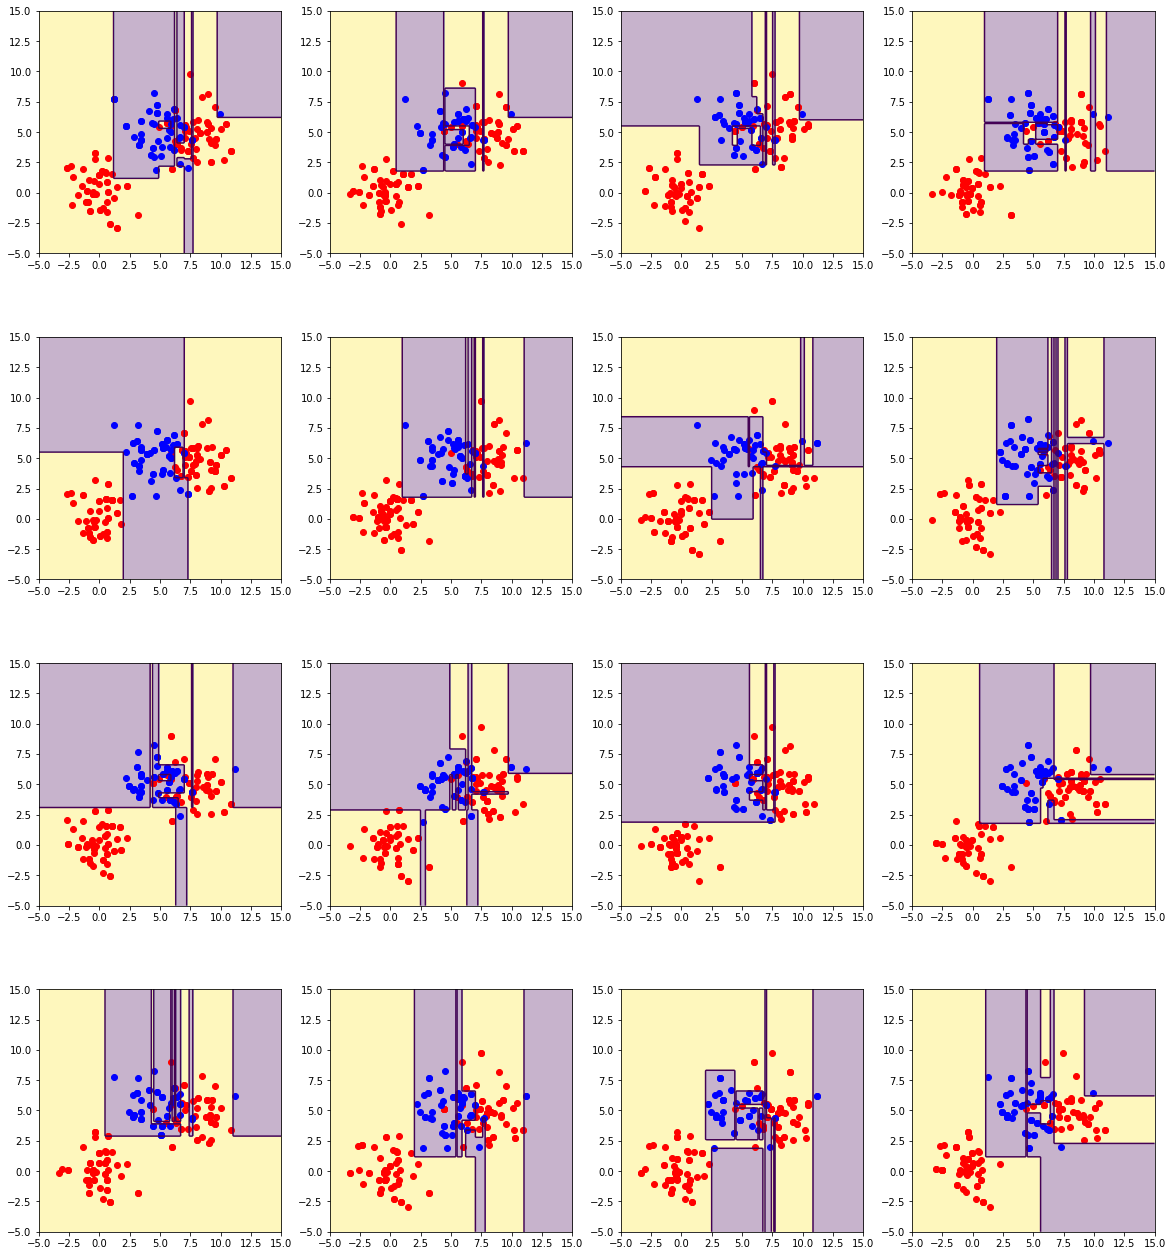

In [7]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append((clf.fit(Xr,yr.ravel()),idx))  #Add the indices for visualization purposes in test
    return clf_list


def visualize_bagged_tree(X,y,clf_list):
    C = len(clf_list)
    x = np.linspace(-5,15,200)
    XX,YY = np.meshgrid(x,x)
    sz=XX.shape
    data=np.c_[XX.ravel(),YY.ravel()]
    yhat=np.zeros((data.shape[0],len(clf_list)))
    i=0
    for dt,idx in clf_list:
        yhat[:,i]=dt.predict(data)
        Xr=X[idx,:]
        yr=y[idx]
        mx= np.max(yhat[:,i])
        mn= np.min(yhat[:,i])
        plt.subplot(int(np.floor(C/4))+1,4,i+1)
        plt.scatter(Xr[(yr==1).ravel(),0],Xr[(yr==1).ravel(),1],color='r')
        plt.scatter(Xr[(yr==-1).ravel(),0],Xr[(yr==-1).ravel(),1],color='b')
        plt.imshow(yhat[:,i].reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
        plt.contour(XX,YY,yhat[:,i].reshape(sz),[0])
        i=i+1
    fig = plt.gcf()
    fig.set_size_inches(20,7*int(np.floor(C/4))+1)
    return yhat


clf_list=train_bagged_tree(X,y,16)
y_pred=visualize_bagged_tree(X,y,clf_list)
y_pred = np.sum(y_pred,axis=1)

print ('Process finnished.')


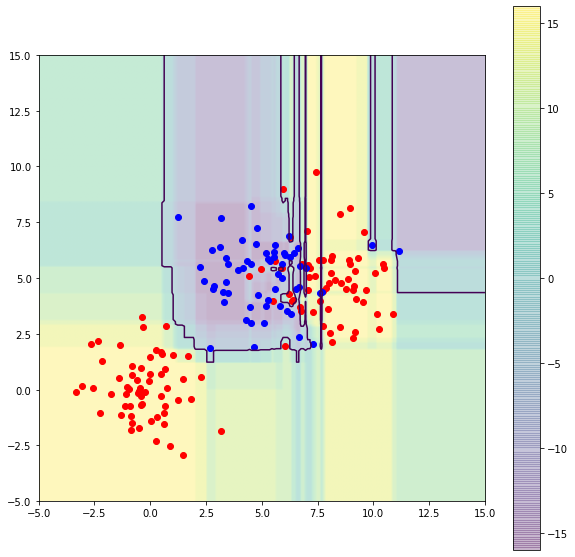

In [8]:
mx= np.max(y_pred)
mn= np.min(y_pred)
plt.figure()
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(y_pred.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,y_pred.reshape(sz),[0])
fig = plt.gcf()
fig.set_size_inches(10,10) 

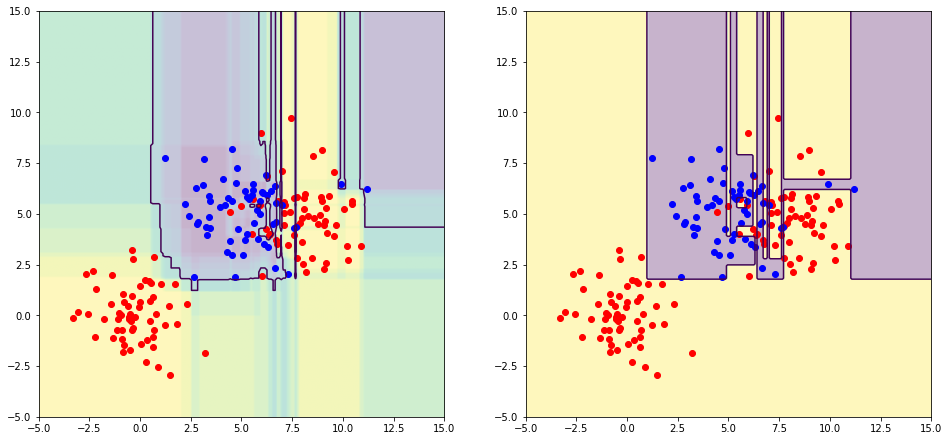

In [9]:
Zb = y_pred.reshape(sz)
plt.subplot(1,2,1)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Zb, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.contour(XX,YY,Zb,[0])
plt.subplot(1,2,2)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(16,9)

### Application to customer churn prediction

Let us check this approach in the Churn problem. Recall that a single decision tree achieved an accuracy of $91.7\%$, precision of $71\%$ and recall of $72\%$

In [10]:
%reset -f
#Recover Churn data
import pandas as pd

df = pd.read_csv("churn_curated_numerical.csv",header=None)
df.head()
data = df.values
X = data[:,:-1]
y = 2*data[:,-1]-1
print ('Loading ok.')

Loading ok.


In [11]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append(clf.fit(Xr,yr.ravel()))  
    return clf_list


def test_bagged_tree(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt in clf_list:
        yhat[:,i]=dt.predict(X)
        i=i+1
    return np.sign(np.mean(yhat,axis=1))

In [13]:
#NO SNOOPING
import numpy as np
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics

kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits()

acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_list = train_bagged_tree(X_train,y_train.ravel(),51)
    yhat[test_index]=test_bagged_tree(X_test,clf_list) 
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.9549963756860309


/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_6511/2422236388.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_6511/2422236388.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, size=20)


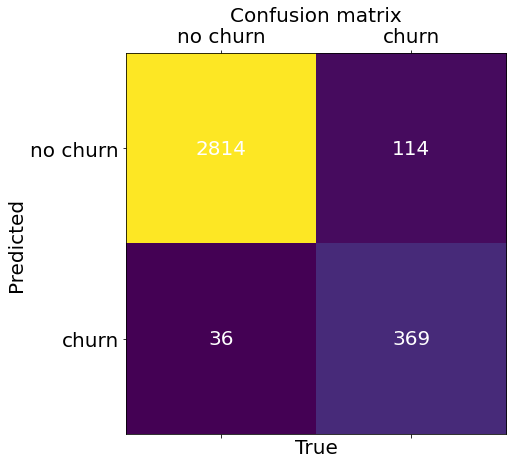

              precision    recall  f1-score   support

        -1.0       0.96      0.99      0.97      2850
         1.0       0.91      0.76      0.83       483

    accuracy                           0.95      3333
   macro avg       0.94      0.88      0.90      3333
weighted avg       0.95      0.95      0.95      3333



In [14]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Observe that the solution accuracy increases by about $5\%$, recall goes upt to $75\%$ and precision also increases up to $91\%$.

<div class="alert alert-info"> **Bagging** performance improvement is due to the reduction of the variance of the classifier while mantaining its bias.
</div>

## Random Forest

Random Forest technique introduces a randomization over the feature selected for building  each tree in the ensemble in order to improve diversity in an attempt to reduce variance evan more. Let us code this variant of bagging.

In [15]:
from sklearn import tree
import numpy as np
def train_random_forest(X,y,C):
    F=int(np.ceil(np.sqrt(X.shape[1])))
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        feat_idx=np.random.permutation(np.arange(X.shape[1]))[:10]
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:].copy()
        Xr=Xr[:,feat_idx]
        yr=y[idx]
        clf_list.append((clf.fit(Xr,yr.ravel()),feat_idx))
    return clf_list


def test_random_forest(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt,feat_idx in clf_list:
        yhat[:,i]=dt.predict(X[:,feat_idx])
        i=i+1
    return np.sign(np.mean(yhat,axis=1)),yhat

In [16]:
from sklearn import metrics
clf_list = train_random_forest(X,y,51)
yhat,yk = test_random_forest(X,clf_list)
acc = metrics.accuracy_score(yhat, y)
print (yk.shape)
print (np.sum(np.mean(yk,axis=1)>0))
print (acc)

(3333, 51)
483
1.0


In [18]:
#NO SNOOPING
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import metrics


kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits()
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #dt = ensemble.RandomForestClassifier(n_estimators=51)
    #dt.fit(X_train,y_train)
    #yhat[test_index]=dt.predict(X_test)
    clf_list = train_random_forest(X_train,y_train,51)
    yhat[test_index],yk = test_random_forest(X_test,clf_list)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print (acc)
print (np.unique(yhat))
print (np.unique(y_test))
print ('Mean accuracy: '+ str(np.mean(acc)))

[0.92953523 0.93553223 0.90254873 0.92642643 0.92642643]
[-1.  1.]
[-1.  1.]
Mean accuracy: 0.9240938089513803


/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_6511/926181432.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_6511/926181432.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, size=20)


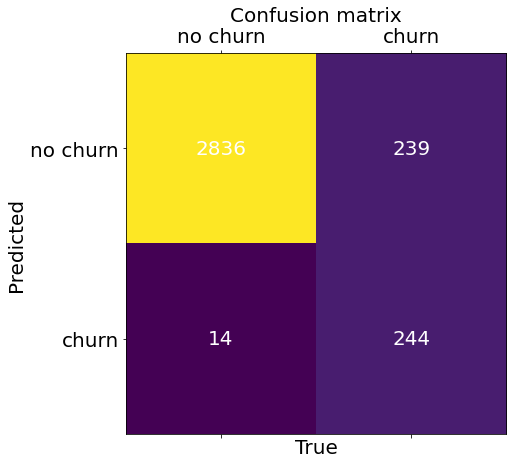

              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96      2850
         1.0       0.95      0.51      0.66       483

    accuracy                           0.92      3333
   macro avg       0.93      0.75      0.81      3333
weighted avg       0.93      0.92      0.91      3333



In [19]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()
draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

# Incremental learning (stage-wise approximation) and boosting techniques

+ Gradient boost
+ Adaboost

Up to now we have seen optimization techniques based on full step optimisation (e.g. gradient descent approaches). This is, we optimise all members of the ensemble at each step. We will now consider stage-wise approximations or incremental approximations. The most simple approach of this family is a greedy stage-wise approximation. In stage-wise approximations we consider the model up to our current time $t$ as fixed, and we just add and optimize a new element of the ensemble.

Our model is

$$H_t(x) = \sum_{t=1}^T \alpha_t h_t(x)$$

Consider for example a least square approach 

$$\mathcal{L}(x,y) = \sum_{j=1}^N (y_j - \sum_{t=1}^T \alpha_t h_t(x_j))^2$$

at time $t+1$, we have to select $h_{t+1}$ and optimize $\alpha_{t+1}$ while keeping the model up to that point constant.

$$H_{t+1}(x) = \sum_{t=1}^T \alpha_t h_t(x) + \alpha_{t+1}h_{t+1}(x)$$

If we plug this model into the loss 

$$\mathcal{L}(x,y) = \sum_{j=1}^N (\underset{r_t(x_j)}{\underbrace{y_j - \sum_{t=1}^T \alpha_t h_t(x_j)}} + \alpha_{t+1}h_{t+1}(x_j))^2$$

where $r_t(x_j) = y_j - H_t(x_j)$ is the error or residue commited by the model at time $t$ on example $x_j$.

In this simple case, we have to solve for $\alpha_{t+1}$ and $h_{t+1}$,

$$\nabla_{h_{t+1}} \sum_{j=1}^N (r_t(x_j) + \alpha_{t+1}h_{t+1}(x_j))^2 = 2\sum_{j=1}^N (r_t(x_j) + \alpha_{t+1}h_{t+1}(x_j))\alpha_{t+1} = 0$$

$$\nabla_{\alpha_{t+1}} \sum_{j=1}^N (r_t(x_j) + \alpha_{t+1}h_{t+1}(x_j))^2 = 2\sum_{j=1}^N (r_t(x_j) + \alpha_{t+1}h_{t+1}(x_j))h_{t+1}(x_j) = 0$$

From the second equation we can see that

$$\sum_{j=1}^N (r_t(x_j)h_{t+1}(x_j) + \alpha_{t+1}h_{t+1}(x_j)h_{t+1}(x_j)) = $$
$$r^T_t(x)h_{t+1}(x) + \alpha_{t+1}h^T_{t+1}(x)h^T_{t+1}(x) = 0$$

Observe that $\alpha_{t+1}$ is proportional to the inner product of the current residue and the candidate function, 

$$\alpha_{t+1} = \frac{r^T_t(x)h_{t+1}(x)}{h^T_{t+1}(x)h_{t+1}(x)}$$

In the *case we have a binary problem* $h^T_{t+1}(x) \in \{-1,+1\}$, $h^T_{t+1}(x)h_{t+1}(x) = N$, the number of samples.

*In this case the selection of the optimum $h$ corresponds to the one that has minimum error.*

This is the core of **gradient boosting techniques**.




Another popular example of boosting is **Adaboost** (Adaptive boosting).

In Adaboost we use the same idea but we change the loss function and use 

$$\mathcal{L}(x,y) = \sum_i e^{-y_iH(x_i)}$$

In this case, let us drop the regularization term for reasons we will see afterwards. Thus, the problem to be optimized is,
$$
	\{\alpha, h(x)\}=\underset{\alpha, h(x)}{\operatorname{arg\,min}} \sum_{i=1}^N e^{-y_i f(x_i)} = \underset{\alpha, h(x)}{\operatorname{arg\,min}} \sum_{i=1}^N e^{-y_i \sum_{j=1}^M \alpha_j h_j(x_i)} 
$$
We use a stage-wise approach as in the former algorithm.

$$
\underset{\alpha, h(x)}{\operatorname{arg\,min}} \sum_{i=1}^N \underset{w_{M-1}(x_i)}{\underbrace{e^{-y_i \sum_{j=1}^{M-1} \alpha_j h_j(x_i)}}} e^{-y_i\alpha_M h_M(x_i)}
$$

Divide in two parts : $h_M(x_i)=y_i$ and $h_M(x_i)\neq y_i$ (Consider that $h_M(x_i)\in\{-1,1\}$)

Divide in two parts : $h_M(x_i)=y_i$ and $h_M(x_i)\neq y_i$ (Consider that $h_M(x_i)\in\{-1,1\}$)

\begin{align*}
 \dots= \underset{\alpha, h(x)}{\operatorname{arg\,min}} \sum_{i=1}^N w_{M-1}(x_i) e^{- y_i \alpha_M h_M(x_i)} = \\
 = e^{-\alpha_M}\sum_{y_i=h_M(x_i)} w_{M-1}(x_i) + e^{\alpha_M}\sum_{y_i\neq h_M(x_i)} w_{M-1}(x_i) = \\
 = (e^{\alpha_M} - e^{-\alpha_M}) \sum_{i=1}^N w_{M-1}(x_i) I(y_i \neq h_M(x_i)) + e^{-\alpha_M} \sum_{i=1}^N w_{M-1}(x_i)
 \end{align*}

 
 Setting the gradient of the learning function to zero and recalling the derived expression (simplified notation ${\bf I} = I(y_i \neq h_M(x_i))$): 
 
\begin{align*}
\frac{\partial}{\partial \alpha_M}\big ( (e^{\alpha_M} - e^{-\alpha_M}) \sum_{i=1}^N w_{M-1}(x_i) {\bf I} + e^{-\alpha_M} \sum_{i=1}^N w_{M-1}(x_i) \big )= 0\\
(e^{\alpha_M} + e^{-\alpha_M})\sum_i w_{M-1}{\bf I} - e^{-\alpha_M} \sum_i w_{M-1}=0\\
(e^{\alpha_M} + e^{-\alpha_M})\frac{\sum_i w_{M-1}{\bf I}}{\sum_i w_{M-1}} - e^{-\alpha_M} =0
\end{align*}
Observe that $\frac{\sum_i w_{M-1}{\bf I}}{\sum_i w_{M-1}}$ is the error (${\bf err}_{M-1}$) at stage $M-1$.

$$
(e^{\alpha_M} + e^{-\alpha_M}) {\bf err}_{M-1} - e^{-\alpha_M} =0
$$

Simple manipulation allows us to isolate $\alpha_M$:

$$
\alpha_M = \frac{1}{2} log \big ( \frac{1- {\bf err}_{M-1} }{ {\bf err}_{M-1} } \big )
$$

Thus the algorithm is as follows:

1. Initialize $w_0(x_i)=1/N.$
2. **for** $m=1\dots M:$
    + Find the function $h_m(x)$ that minimizes the weighted error $$h_m(x)=\underset{h}{\operatorname{arg\,min}}\sum_i w_{m-1}(x_i) I(h_m(x_i)\neq y_i)$$
    + Compute the weighted error $$ {\bf err}_{m-1}=\frac{\sum_i w_{m-1}{\bf I}}{\sum_i w_{m-1}}$$.
    + Choose $$\alpha_m=\frac{1}{2}\ln\big(\frac{1-{\bf err}_{m-1}}{{\bf err}_{m-1}}\big)$$
    + Update the weights:
$$
w_m(x_i)=\frac{w_{m-1}(x_i) e^{- y \alpha_m h_m(x_i)}}{Z_m}
$$
where $Z_m=\sum_i w_m(x_i)$ is a normalization factor.

    + Update model: $$f_{m}(x)=f_{m-1}(x)+\alpha_{m}h_m(x)$$


# 3. Reductionist frameworks for the multi-class problems 

Up to this moment we have applied several models in multi-class problems but we have barely talked about the problem of multiple classes in learning. 

First of all, there are very few models that intrinsically handle the multi-class case. By intrinsically handling the multi-class problem I am referring to methods in which we do not have to worry about how many classes our problem has. The two big families of models that can deal with the problem are

+ Decision trees: the leaves encode the class.
+ Nearest Neighbors: we only care about class labels of instances close to my query sample.

What about the rest of the models? Did not Bayesian models or Neural Networks also handle this problem? Yes, they work in the multi-class case. But we have to worry about how many classes there are. In particular we have to build a model for each class and then take a maximum score/probability/confidence among the predictions. This way of addressing the multiclass problem is also known as **one-against-all** because we consider one model for each class while the samples from the rest of the classes are considered as negative samples. This is the first example of a reductionist framework.

The reductionist framework refers to those ensemble methods that allows to reduce the multi-class problem to a set of binary problems. In a $K$ class problem, the two most common approaches in this framework are:

+ **one-against-all:** We consider $K$ partitions of the problem, corresponding to setting one class as positive class and the rest as negative. 
+ **one-against-one:** We consider all posible pairs of classes and build a model for each subproblem. 

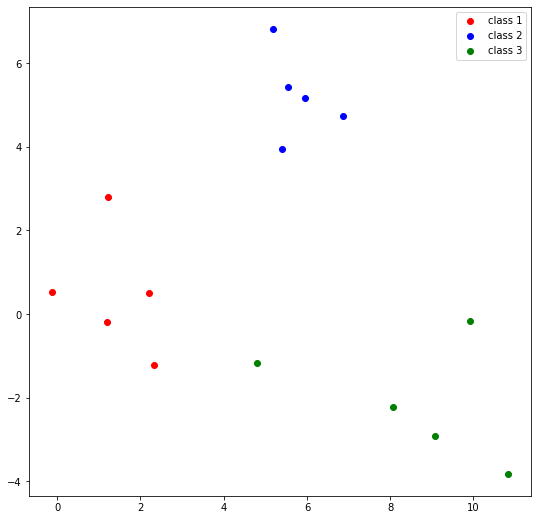

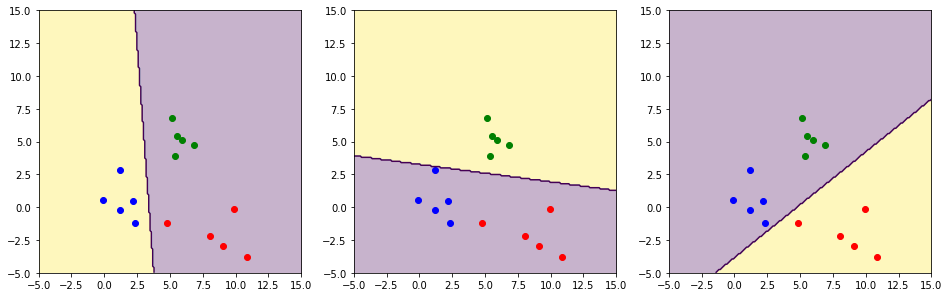

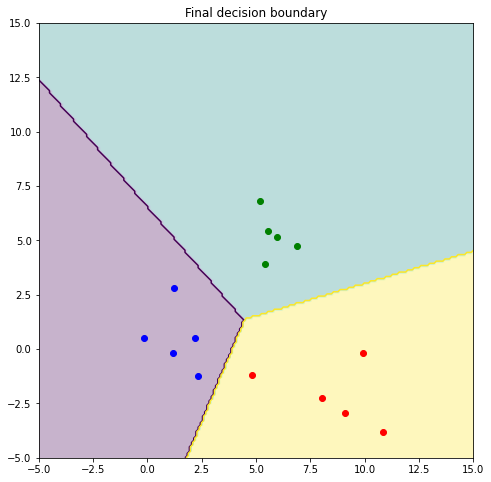

In [20]:
%reset -f
#Create a multiclass toy problem
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
MAXN=5
np.random.seed(0)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.25*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,-2]+1.25*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

#Display data
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g',label='class 3')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(9,9)

#Train a LinearSVC in one-vs-all fashion
clf_list=[]
for i in range(3):
    clf = svm.LinearSVC()
    y_meta = y.copy()
    #Create a binary problem with one class at +1 and the rest at -1
    y_meta=np.where(y_meta == i+1 ,1,-1)
    clf_list.append(clf.fit(X,y_meta.ravel()))

#Test each classifier
plt.figure()
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
i=1
yhat_d=np.empty((data.shape[0],3))
for c in clf_list:
    yhat=c.predict(data)
    #Visualization of each boundary
    yhat_d[:,i-1]=c.decision_function(data)
    mn = np.min(yhat)
    mx = np.max(yhat)
    plt.subplot(1,3,i)
    plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
    plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
    plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
    plt.imshow(yhat.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
    plt.contour(XX,YY,yhat.reshape(sz),[0])
    i=i+1
fig = plt.gcf()
fig.set_size_inches(16,9)

y_final=np.argmax(yhat_d,axis=1)
plt.figure()
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)

## 3.1 Error correcting output coding

Error correcting output coding is a generalization of the methods shown before. In the most general case each class is assigned a ternary code $c_i \in \{+1,0,-1\}^l$ with length $l$. This step is called **coding**. In testing a new sample will be given a test code and this will be compared according to some distance to the class codewords. The class with the closest codeword will be selected as the predicted class. This step is called **decoding**.



### 3.1.1 Understanding the coding step
If we arrange the codewords as rows in a matrix we obtain the coding matrix $M \in \{+1,0,-1\}^{K\times l}$. Consider the following example with four classes and code length $l=3$:

<table>
  <tr>
    <th></th>
    <th>$h_1$</th>
    <th>$h_2$</th>
    <th>$h_3$</th>
  </tr>
  <tr>
    <th>$y_1$</th>
    <th>$1$</th>
    <th>$1$</th>
    <th>$1$</th>
  </tr>
    <tr>
    <th>$y_2$</th>
    <th>$1$</th>
    <th>$-1$</th>
    <th>$0$</th>
  </tr>
    <tr>
    <th>$y_3$</th>
    <th>$-1$</th>
    <th>$0$</th>
    <th>$1$</th>
  </tr>
    <tr>
    <th>$y_4$</th>
    <th>$-1$</th>
    <th>$0$</th>
    <th>$-1$</th>
  </tr>
</table>

The first class, $y_1$ is coded as $(1,1,1)$, the second $y_2$ is coded as $(1,-1,0)$, and so on.

Note that the columns of the matrix define a binary problem involving all the classes in the following way: in same column, all classes with code $+1$ belongs to the same meta-class, all classes with code $-1$ to the other meta-class, and all classes with code $0$ are not considered in that particular problem. In our example, the first column defines a binary problem involving the discrimination of all samples from classes $y_1,y_2$ (coded as $+1$) against all the samples of $y_3,y_4$ (coded as $-1$). The second column only considers the samples of class $y_1$ against the samples of class $y_2$. Note that all the zero coded classes are not considered. 

Given a coding matrix a classifier is trained for each column according to the column defined binary problem. 


<div class="alert alert-success">**EXERCISE:** Which are the coding matrix of one-vs-one and one-vs-all?
</div>

>One vs one:
We have 1 and -1 for the two we are comparing and 0 for the remaining classes. 
One vs all:
We have 1 on the one separated, and -1 on all the other classes. 

### 3.1.2 Understanding the decoding step

Given a set of classifiers trained according to the problems defined by the columns of the coding matrix, in the prediction step all the classifiers are applyed to the testing sample. As a result a binary code $t$ is obtained. This coded is compared to all the class codes according to some decoding/distance metric. The most common ones are:

+ Hamming decoding/$\ell_1$-decoding
$$d(a,b) = \frac{1}{2}\sum\limits_{i=1}^l |a_i-b_i|$$

+ Euclidean decoding
$$d(a,b) = \sqrt{\sum\limits_{i=1}^l (a_i-b_i)^2}$$

For example, consider that $t=(-1,-1,-1)$. Note that there is no exact code in the coding matrix, thus we have to check for the closest one. If we apply Hamming decoding we obtain

<table>
  <tr>
    <th></th>
    <th>Hamming</th>
    <th>Euclidean</th>
  </tr>
  <tr>
    <th>$y_1$</th>
    <th>$3$</th>
    <th>$\sqrt{12}$</th>
  </tr>
    <tr>
    <th>$y_2$</th>
    <th>$\frac{3}{2}$</th>
    <th>$\sqrt{5}$</th>
  </tr>
    <tr>
    <th>$y_3$</th>
    <th>$\frac{3}{2}$</th>
    <th>$\sqrt{5}$</th>
  </tr>
    <tr>
    <th>$y_4$</th>
    <th>$\frac{1}{2}$</th>
    <th>$1$</th>
  </tr>
</table>

Observe that in both cases the sample will be predicted as class $y_4$.

Let us apply this framework to the former problem using a one-vs-all approach:

Coding matrix M = 
[[ 1 -1 -1]
 [-1  1 -1]
 [-1 -1  1]]


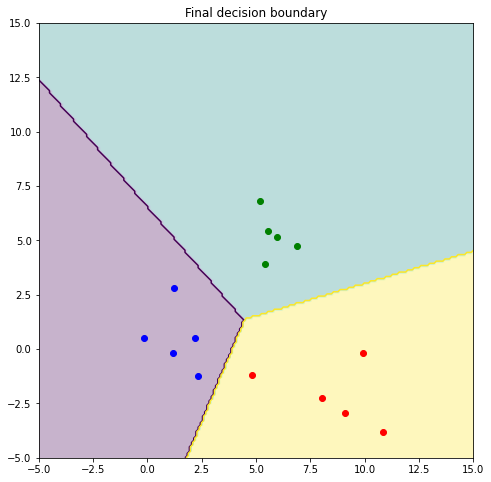

In [23]:
%reset -f
#Create a multiclass toy problem
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
MAXN=5
np.random.seed(0)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.25*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,-2]+1.25*np.random.randn(MAXN,2)])
y = np.concatenate([0*np.ones((MAXN,1)),1*np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]

#Define the coding matrix
M = np.array([[1, -1, -1],[-1, 1, -1],[-1, -1, 1]]) #1vsAll
#M = np.array([[1, 1, 0 ],[-1, 0, 1],[0, -1, -1]]) #1vs1

print ('Coding matrix M = \n' + str(M))
def inset(a,b): 
    return [item in b for item in a]

def fit_ECOC(X, y, M):
    clf_list=[]
    for i in range(M.shape[1]): #For each column
        y_meta=y.copy()
        idx_c1 = np.where(inset(y, np.where(M[:,i]==1)[0]))[0]
        idx_c2 = np.where(inset(y, np.where(M[:,i]==-1)[0]))[0]
        clf = svm.LinearSVC()
        clf_list.append(clf.fit(np.r_['0',X[idx_c1,:],X[idx_c2,:]],np.r_['0',np.ones((idx_c1.shape[0],1)),-np.ones((idx_c2.shape[0],1))].ravel()))
    return clf_list

def predict_ECOC(X,M, clf_list):
    #Test codes
    c = np.zeros((X.shape[0],M.shape[1]))
    for i in range(M.shape[1]):
        c[:,i]=clf_list[i].decision_function(X) #SOFT CODES
        #c[:,i]=clf_list[i].predict(X) #HARD CODES 
    #Use Euclidean distance
    i=0
    d = np.zeros((X.shape[0],M.shape[0]))
    for code in M:
        d[:,i]=np.sum(np.power((c-code),2),axis=1)
        i=i+1
    return np.argmin(d,axis=1)    


clf_list=fit_ECOC(X,y,M)
y_final = predict_ECOC(data,M,clf_list)

plt.scatter(X[(y==0).ravel(),0],X[(y==0).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='r',label='class 3')
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)

<div class="alert alert-success">
**EXERCISE:** Replace the hard codes prediction by the soft coding by changing in the ECOC_predict() function the ".predict" by ".decision_function". Run the algorithm with one-against-all approach. What do you observe?
</div>

The decision boundary in the hard code is less linear and adjust the model in a way that looks like all the points are predicted with the same precision. It looks like it tries to adjust and equalize the distance each point from a class has to the decision boundary. 

<div class="alert alert-success">
**EXERCISE:** Replace the coding matrix by one-vs-one.
</div>

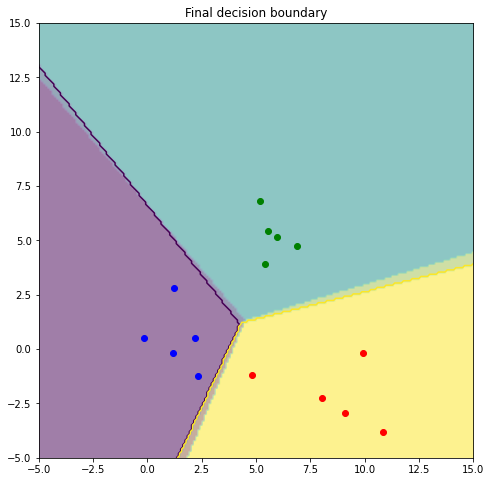

In [24]:
M = np.array([[1, 1, 0 ],[-1, 0, 1],[0, -1, -1]])
clf_list=fit_ECOC(X,y,M)
y_final2 = predict_ECOC(data,M,clf_list)

plt.scatter(X[(y==0).ravel(),0],X[(y==0).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='r',label='class 3')
plt.imshow(y_final2.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)

plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final2.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)

# [Bonus content] Extreme learning machines or whatever...

This is just a simple random projection followed by a non-linearity and a straight forward least squares optimization. Let us code that.

array([-0.87353053,  1.04533718,  0.96036347, -0.92445114, -1.17614391,
       -1.00088192, -0.99836251, -0.86649843,  1.0224554 ,  0.91417372,
        1.03702576,  1.14334938,  0.89397032,  1.03848276, -1.00867127,
       -1.01672356, -1.03754721, -1.09786458,  1.00996494, -1.06115052,
        1.03867838, -0.97505774, -0.94378617,  1.00962719, -0.88943429,
       -0.79268814,  0.97571515,  1.00266438,  1.03750786,  0.38787403,
       -1.04111536, -0.47770735,  1.02959498,  0.77645126, -0.81636498,
        0.98513624,  1.00851635,  1.08969463, -0.67850183, -1.16166838,
        1.04727665, -1.00062953, -1.12451834,  1.01499215, -1.00323501,
        1.01955096,  1.06119913, -0.76739443,  1.06726133, -0.9897765 ,
       -1.06334142,  1.03559821, -1.06823563, -1.0333554 , -1.04875903,
        1.02252056,  1.02758039,  0.95694811,  0.99619678,  0.96979228,
       -1.13362725,  1.02097288, -0.94698717, -1.06016095,  0.5807237 ,
        0.88550314,  0.91452076,  1.06704319,  0.80077138,  1.04

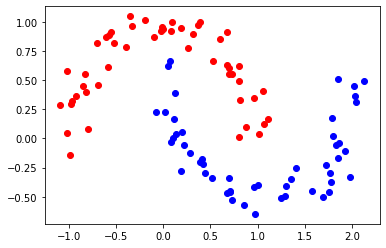

In [25]:
%matplotlib inline
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

#Create data
x,y = make_moons(noise=0.1)
y=2.*y-1.
plt.scatter(x[y==1,0],x[y==1,1],color='b',label='class 1')
plt.scatter(x[y==-1,0],x[y==-1,1],color='r',label='class 2')


#Code xlm
layer1_size = 600
dim = 2
lam = 0.5
W_in = np.random.normal(size=(dim+1,layer1_size)) 
z_in = np.dot(x,W_in[:-1,:])+W_in[-1,:]
z_out = np.where(z_in<0,0,z_in)
z_out = np.c_[z_out,np.ones((z_out.shape[0],1))]
den = np.linalg.inv(np.dot(z_out.T,z_out)+lam*np.eye(z_out.shape[1]))
num = np.dot(z_out.T,y)
W_out=np.dot(den,num)

def eval_xlm(W_in,W_out,data):
    z_in = np.dot(data,W_in[:-1,:])+W_in[-1,:]    
    z_out = np.where(z_in<0,0,z_in)
    z_out = np.c_[z_out,np.ones((z_out.shape[0],1))]
    return np.dot(z_out,W_out)

eval_xlm(W_in,W_out,x)

(40000, 2)
(40000,)


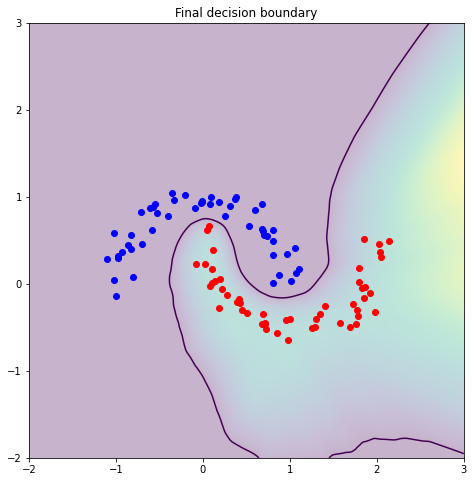

In [26]:
plt.figure()
plt.scatter(x[y==1,0],x[y==1,1],color='r',label='class 1')
plt.scatter(x[y==-1,0],x[y==-1,1],color='b',label='class 2')
xlin = np.linspace(-2,3,200)
XX,YY = np.meshgrid(xlin,xlin)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
print (data.shape)
y_final = eval_xlm(W_in,W_out,data)
print (y_final.shape)
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-2,3,-2,3),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)
